# Data Mining Project
### Giorgio Donati, g.donati24@studenti.unipi.it
### Pietro Francaviglia, p.francaviglia1@studenti.unipi.it
#### A.Y. 2021-2022


## Libraries and datasets

In [349]:
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

In [350]:
# load datasets
original_basket_df = pd.read_csv('datasets/baskets_supermarket.csv')
original_categories_df = pd.read_csv('datasets/item_categories.csv')
original_items_df = pd.read_csv('datasets/items.csv')

In [351]:
# global variables for column names
# existing
ITEM = 'item_id'
CAT = 'item_category_id'
DATE = 'date'
SHOP = 'shop_id'
UPRICE = 'item_price'
QTY = 'item_cnt_day'
USER = 'user_id'
BASKET = 'basket_id'
INAME = 'item_name'
CNAME = 'item_category_name'

# new
TMP = 'temp_id'
TPRICE = 'total_price'
BDQTY = 'item_dist_count'
BQTY = 'item_count'

In [429]:
original_basket_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504087 entries, 0 to 504086
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    504087 non-null  int64         
 1   date          352861 non-null  datetime64[ns]
 2   shop_id       469023 non-null  Int64         
 3   item_id       405085 non-null  Int64         
 4   item_price    451795 non-null  float64       
 5   item_cnt_day  497039 non-null  Int64         
 6   user_id       433351 non-null  Int64         
 7   basket_id     437967 non-null  object        
dtypes: Int64(4), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 32.7+ MB


In [431]:
original_items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [432]:
original_categories_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


## Basket dataset

In [430]:
basket_df = original_basket_df

### Cleaning ID columns

In [353]:
non_floating_attributes = [SHOP, ITEM, QTY, USER]
for col in non_floating_attributes:
    basket_df[col] = basket_df[col].astype('Int64')

basket_df[DATE] = pd.to_datetime(basket_df[DATE])
    
basket_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504087 entries, 0 to 504086
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    504087 non-null  int64         
 1   date          352861 non-null  datetime64[ns]
 2   shop_id       469023 non-null  Int64         
 3   item_id       405085 non-null  Int64         
 4   item_price    451795 non-null  float64       
 5   item_cnt_day  497039 non-null  Int64         
 6   user_id       433351 non-null  Int64         
 7   basket_id     437967 non-null  object        
dtypes: Int64(4), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 32.7+ MB


#### Subset with basket_id

In [354]:
stored_basket_df = basket_df[basket_df[BASKET].notna()]
stored_basket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 437967 entries, 0 to 504086
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    437967 non-null  int64         
 1   date          306631 non-null  datetime64[ns]
 2   shop_id       407650 non-null  Int64         
 3   item_id       352049 non-null  Int64         
 4   item_price    392583 non-null  float64       
 5   item_cnt_day  431863 non-null  Int64         
 6   user_id       376422 non-null  Int64         
 7   basket_id     437967 non-null  object        
dtypes: Int64(4), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 31.7+ MB


In [355]:
def integrate(int_attr, gr_attr, df):
    df[int_attr] = df.groupby(gr_attr)[int_attr].apply(lambda x: x.fillna(x.mode().iloc[0] if len(x.mode()) == 1 else x))

In [356]:
basket_dependent_attributes = [DATE, SHOP, USER]
for attr in basket_dependent_attributes:
    integrate(attr, BASKET, stored_basket_df)

stored_basket_df = stored_basket_df.dropna(subset=basket_dependent_attributes, thresh=2)
    
stored_basket_df.info()

/var/folders/qc/cq4vvhlx6msd3j5kh8vlw_cm0000gn/T/ipykernel_11775/631791158.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[int_attr] = df.groupby(gr_attr)[int_attr].apply(lambda x: x.fillna(x.mode().iloc[0] if len(x.mode()) == 1 else x))
/var/folders/qc/cq4vvhlx6msd3j5kh8vlw_cm0000gn/T/ipykernel_11775/631791158.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[int_attr] = df.groupby(gr_attr)[int_attr].apply(lambda x: x.fillna(x.mode().iloc[0] if len(x.mode()) == 1 else x))


<class 'pandas.core.frame.DataFrame'>
Int64Index: 437708 entries, 0 to 504086
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    437708 non-null  int64         
 1   date          435787 non-null  datetime64[ns]
 2   shop_id       437524 non-null  Int64         
 3   item_id       351844 non-null  Int64         
 4   item_price    392353 non-null  float64       
 5   item_cnt_day  431606 non-null  Int64         
 6   user_id       437212 non-null  Int64         
 7   basket_id     437708 non-null  object        
dtypes: Int64(4), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 31.7+ MB


/var/folders/qc/cq4vvhlx6msd3j5kh8vlw_cm0000gn/T/ipykernel_11775/631791158.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[int_attr] = df.groupby(gr_attr)[int_attr].apply(lambda x: x.fillna(x.mode().iloc[0] if len(x.mode()) == 1 else x))


#### Subset without basket_id

In [357]:
null_basket_df = basket_df[basket_df[BASKET].isna()]

null_basket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66120 entries, 20 to 504077
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Unnamed: 0    66120 non-null  int64         
 1   date          46230 non-null  datetime64[ns]
 2   shop_id       61373 non-null  Int64         
 3   item_id       53036 non-null  Int64         
 4   item_price    59212 non-null  float64       
 5   item_cnt_day  65176 non-null  Int64         
 6   user_id       56929 non-null  Int64         
 7   basket_id     0 non-null      object        
dtypes: Int64(4), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.8+ MB


In [358]:
null_basket_df = null_basket_df.dropna(subset=basket_dependent_attributes)
null_basket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36987 entries, 61 to 504077
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Unnamed: 0    36987 non-null  int64         
 1   date          36987 non-null  datetime64[ns]
 2   shop_id       36987 non-null  Int64         
 3   item_id       29726 non-null  Int64         
 4   item_price    33150 non-null  float64       
 5   item_cnt_day  36454 non-null  Int64         
 6   user_id       36987 non-null  Int64         
 7   basket_id     0 non-null      object        
dtypes: Int64(4), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 2.7+ MB


In [359]:
null_basket_df[TMP] = null_basket_df.groupby(basket_dependent_attributes).ngroup().astype(int)

In [360]:
new_basket_df = null_basket_df[null_basket_df.duplicated(subset=[TMP], keep=False)]
new_basket_df[BASKET] = 'R' + null_basket_df[TMP].astype(str)
new_basket_df = new_basket_df.drop(TMP, 1)
new_basket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27748 entries, 61 to 504051
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Unnamed: 0    27748 non-null  int64         
 1   date          27748 non-null  datetime64[ns]
 2   shop_id       27748 non-null  Int64         
 3   item_id       22323 non-null  Int64         
 4   item_price    24897 non-null  float64       
 5   item_cnt_day  27342 non-null  Int64         
 6   user_id       27748 non-null  Int64         
 7   basket_id     27748 non-null  object        
dtypes: Int64(4), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 2.0+ MB


/var/folders/qc/cq4vvhlx6msd3j5kh8vlw_cm0000gn/T/ipykernel_11775/4133404889.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_basket_df[BASKET] = 'R' + null_basket_df[TMP].astype(str)
/var/folders/qc/cq4vvhlx6msd3j5kh8vlw_cm0000gn/T/ipykernel_11775/4133404889.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  new_basket_df = new_basket_df.drop(TMP, 1)


In [361]:
single_basket_df = null_basket_df.drop_duplicates(subset=[TMP], keep=False)
single_basket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9239 entries, 121 to 504077
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Unnamed: 0    9239 non-null   int64         
 1   date          9239 non-null   datetime64[ns]
 2   shop_id       9239 non-null   Int64         
 3   item_id       7403 non-null   Int64         
 4   item_price    8253 non-null   float64       
 5   item_cnt_day  9112 non-null   Int64         
 6   user_id       9239 non-null   Int64         
 7   basket_id     0 non-null      object        
 8   temp_id       9239 non-null   int64         
dtypes: Int64(4), datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 757.9+ KB


In [362]:
restoring_basket_df = pd.concat([stored_basket_df, single_basket_df])
restoring_basket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 446947 entries, 0 to 504077
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    446947 non-null  int64         
 1   date          445026 non-null  datetime64[ns]
 2   shop_id       446763 non-null  Int64         
 3   item_id       359247 non-null  Int64         
 4   item_price    400606 non-null  float64       
 5   item_cnt_day  440718 non-null  Int64         
 6   user_id       446451 non-null  Int64         
 7   basket_id     437708 non-null  object        
 8   temp_id       9239 non-null    float64       
dtypes: Int64(4), datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 35.8+ MB


In [363]:
integrate(BASKET, basket_dependent_attributes, restoring_basket_df)
restoring_basket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 446947 entries, 0 to 504077
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    446947 non-null  int64         
 1   date          445026 non-null  datetime64[ns]
 2   shop_id       446763 non-null  Int64         
 3   item_id       359247 non-null  Int64         
 4   item_price    400606 non-null  float64       
 5   item_cnt_day  440718 non-null  Int64         
 6   user_id       446451 non-null  Int64         
 7   basket_id     443752 non-null  object        
 8   temp_id       9239 non-null    float64       
dtypes: Int64(4), datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 35.8+ MB


In [364]:
restoring_basket_df = restoring_basket_df.dropna(subset=[BASKET, DATE, SHOP, USER], thresh=3)
restoring_basket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 444346 entries, 0 to 504077
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    444346 non-null  int64         
 1   date          444346 non-null  datetime64[ns]
 2   shop_id       444346 non-null  Int64         
 3   item_id       357166 non-null  Int64         
 4   item_price    398288 non-null  float64       
 5   item_cnt_day  438157 non-null  Int64         
 6   user_id       444346 non-null  Int64         
 7   basket_id     443752 non-null  object        
 8   temp_id       9239 non-null    float64       
dtypes: Int64(4), datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 35.6+ MB


In [365]:
restoring_basket_df[BASKET] = restoring_basket_df[BASKET].fillna('S' + restoring_basket_df[TMP].astype(str))
restoring_basket_df = restoring_basket_df.drop(TMP, 1)
restoring_basket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 444346 entries, 0 to 504077
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    444346 non-null  int64         
 1   date          444346 non-null  datetime64[ns]
 2   shop_id       444346 non-null  Int64         
 3   item_id       357166 non-null  Int64         
 4   item_price    398288 non-null  float64       
 5   item_cnt_day  438157 non-null  Int64         
 6   user_id       444346 non-null  Int64         
 7   basket_id     444346 non-null  object        
dtypes: Int64(4), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 32.2+ MB


/var/folders/qc/cq4vvhlx6msd3j5kh8vlw_cm0000gn/T/ipykernel_11775/2587483246.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  restoring_basket_df = restoring_basket_df.drop(TMP, 1)


#### Merging subsets

In [366]:
clean_basket_df = pd.concat([restoring_basket_df, new_basket_df])
clean_basket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 472094 entries, 0 to 504051
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    472094 non-null  int64         
 1   date          472094 non-null  datetime64[ns]
 2   shop_id       472094 non-null  Int64         
 3   item_id       379489 non-null  Int64         
 4   item_price    423185 non-null  float64       
 5   item_cnt_day  465499 non-null  Int64         
 6   user_id       472094 non-null  Int64         
 7   basket_id     472094 non-null  object        
dtypes: Int64(4), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 34.2+ MB


### Cleaning item columns

In [367]:
clean_basket_df = clean_basket_df.dropna(subset=QTY)
clean_basket_df = clean_basket_df[clean_basket_df[QTY] > 0]
clean_basket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 464180 entries, 0 to 504051
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    464180 non-null  int64         
 1   date          464180 non-null  datetime64[ns]
 2   shop_id       464180 non-null  Int64         
 3   item_id       373163 non-null  Int64         
 4   item_price    416080 non-null  float64       
 5   item_cnt_day  464180 non-null  Int64         
 6   user_id       464180 non-null  Int64         
 7   basket_id     464180 non-null  object        
dtypes: Int64(4), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 33.6+ MB


In [368]:
clean_basket_df = clean_basket_df.dropna(subset=[ITEM, UPRICE], thresh=1)
clean_basket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 454723 entries, 0 to 504051
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    454723 non-null  int64         
 1   date          454723 non-null  datetime64[ns]
 2   shop_id       454723 non-null  Int64         
 3   item_id       373163 non-null  Int64         
 4   item_price    416080 non-null  float64       
 5   item_cnt_day  454723 non-null  Int64         
 6   user_id       454723 non-null  Int64         
 7   basket_id     454723 non-null  object        
dtypes: Int64(4), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 33.0+ MB


In [369]:
clean_basket_df[ITEM] = clean_basket_df[ITEM].fillna(-1)
clean_basket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 454723 entries, 0 to 504051
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    454723 non-null  int64         
 1   date          454723 non-null  datetime64[ns]
 2   shop_id       454723 non-null  Int64         
 3   item_id       454723 non-null  Int64         
 4   item_price    416080 non-null  float64       
 5   item_cnt_day  454723 non-null  Int64         
 6   user_id       454723 non-null  Int64         
 7   basket_id     454723 non-null  object        
dtypes: Int64(4), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 33.0+ MB


In [370]:
temp = clean_basket_df.groupby(ITEM)[UPRICE].mean()
priced_items_df = pd.merge(original_items_df, temp, on=ITEM, how='outer')
priced_items_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22171 entries, 0 to 22170
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   item_name         22170 non-null  object 
 1   item_id           22171 non-null  Int64  
 2   item_category_id  22170 non-null  float64
 3   item_price        16814 non-null  float64
dtypes: Int64(1), float64(2), object(1)
memory usage: 887.7+ KB


In [371]:
clean_basket_df = clean_basket_df.set_index(ITEM).join(priced_items_df.set_index(ITEM), lsuffix='', rsuffix='_temp').reset_index()
clean_basket_df[UPRICE] = clean_basket_df[UPRICE].fillna(clean_basket_df['item_price_temp'])
clean_basket_df = clean_basket_df.drop([INAME, CAT, 'item_price_temp'], axis=1)
clean_basket_df = clean_basket_df.dropna()
clean_basket_df = clean_basket_df.drop('Unnamed: 0', axis=1)

clean_basket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 454412 entries, 0 to 454722
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   item_id       454412 non-null  Int64         
 1   date          454412 non-null  datetime64[ns]
 2   shop_id       454412 non-null  Int64         
 3   item_price    454412 non-null  float64       
 4   item_cnt_day  454412 non-null  Int64         
 5   user_id       454412 non-null  Int64         
 6   basket_id     454412 non-null  object        
dtypes: Int64(4), datetime64[ns](1), float64(1), object(1)
memory usage: 29.5+ MB


## Data visualization

In [372]:
total_df = clean_basket_df

### Basket number

In [373]:
b_df = total_df.groupby([BASKET])[BASKET]
basketsCount = len(b_df)
basketsCount

42252

### Baskets have same shop, user and date

In [374]:
shops = len(total_df.groupby([BASKET, SHOP])[[BASKET, SHOP]])
users = len(total_df.groupby([BASKET, USER])[[BASKET, USER]])
dates = len(total_df.groupby([BASKET, DATE])[[BASKET, DATE]])

if (shops == basketsCount and users == basketsCount and dates == basketsCount):
    print(True)

True


### Record total price

In [375]:
# total price
total_df[TPRICE] = total_df[UPRICE] * total_df[QTY]
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 454412 entries, 0 to 454722
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   item_id       454412 non-null  Int64         
 1   date          454412 non-null  datetime64[ns]
 2   shop_id       454412 non-null  Int64         
 3   item_price    454412 non-null  float64       
 4   item_cnt_day  454412 non-null  Int64         
 5   user_id       454412 non-null  Int64         
 6   basket_id     454412 non-null  object        
 7   total_price   454412 non-null  Float64       
dtypes: Float64(1), Int64(4), datetime64[ns](1), float64(1), object(1)
memory usage: 33.4+ MB


### Domains

In [396]:
total_df.min()

item_id                          -1
date            2013-01-01 00:00:00
shop_id                           0
item_price                      0.1
item_cnt_day                      1
user_id                           1
basket_id                       B11
total_price                     0.1
dtype: object

In [397]:
total_df.mean()

/var/folders/qc/cq4vvhlx6msd3j5kh8vlw_cm0000gn/T/ipykernel_11775/3229925861.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  total_df.mean()
/var/folders/qc/cq4vvhlx6msd3j5kh8vlw_cm0000gn/T/ipykernel_11775/3229925861.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  total_df.mean()


item_id         8388.217664
shop_id           32.699693
item_price       869.324121
item_cnt_day       1.249773
user_id          411.743044
total_price     1099.640946
dtype: float64

In [398]:
total_df.max()

item_id                       22168
date            2015-06-10 00:00:00
shop_id                          59
item_price                  35990.0
item_cnt_day                    512
user_id                         824
basket_id                   S9966.0
total_price               1044450.0
dtype: object

### Basket table

In [377]:
# make tab for basket (basket price, user, date, shop, basket quantity)
b_df = pd.DataFrame()
b_df[BASKET] = total_df.groupby([BASKET])[[BASKET]].first()
b_df[DATE] = total_df.groupby([BASKET])[[DATE]].first()
b_df[USER] = total_df.groupby([BASKET])[[USER]].first().astype(int)
b_df[SHOP] = total_df.groupby([BASKET])[[SHOP]].first().astype(int)
b_df[TPRICE] = total_df.groupby([BASKET])[[TPRICE]].sum().astype(float)
b_df[BDQTY] = total_df.groupby([BASKET])[[BASKET]].size()
b_df[BQTY] = total_df.groupby([BASKET])[[QTY]].sum().astype(int)
b_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42252 entries, B11 to S9966.0
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   basket_id        42252 non-null  object        
 1   date             42252 non-null  datetime64[ns]
 2   user_id          42252 non-null  int64         
 3   shop_id          42252 non-null  int64         
 4   total_price      42252 non-null  float64       
 5   item_dist_count  42252 non-null  int64         
 6   item_count       42252 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 2.6+ MB


<AxesSubplot:xlabel='basket_id'>

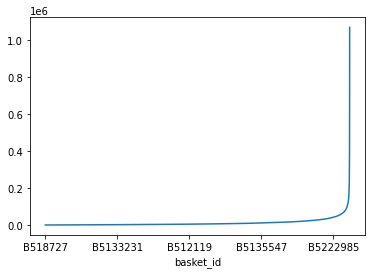

In [414]:
b_df[TPRICE].sort_values().plot()

<AxesSubplot:xlabel='basket_id'>

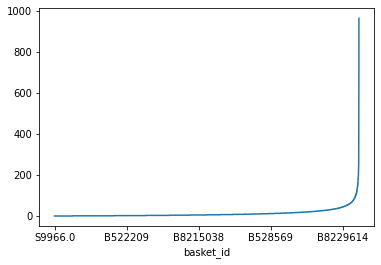

In [415]:
b_df[BQTY].sort_values().plot()

<AxesSubplot:xlabel='basket_id'>

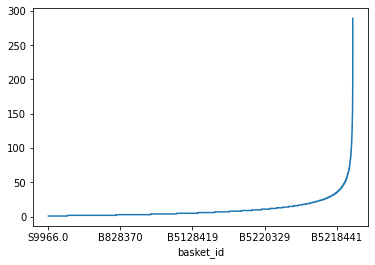

In [416]:
b_df[BDQTY].sort_values().plot()

In [379]:
# make tab for user (total spent, item bought, average basket price, basket bought)
u_df = pd.DataFrame()
u_df[USER] = total_df.groupby([USER])[[USER]].first().astype(int)
u_df[TPRICE] = total_df.groupby([USER])[[TPRICE]].sum().astype(float)
u_df[BQTY] = total_df.groupby([USER])[[QTY]].sum().astype(int)
u_df[BDQTY] = total_df.groupby([USER])[[ITEM]].count()
u_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 824 entries, 1 to 824
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          824 non-null    int64  
 1   total_price      824 non-null    float64
 2   item_count       824 non-null    int64  
 3   item_dist_count  824 non-null    int64  
dtypes: float64(1), int64(3)
memory usage: 33.0 KB


<AxesSubplot:xlabel='user_id'>

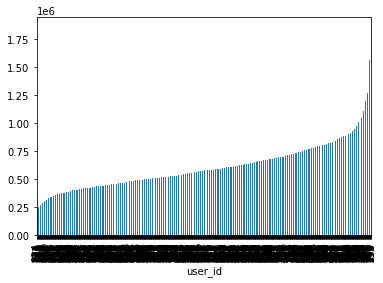

In [420]:
u_df[TPRICE].sort_values().plot(kind='bar')

<AxesSubplot:xlabel='user_id'>

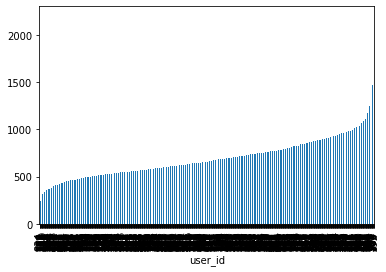

In [421]:
u_df[BQTY].sort_values().plot(kind='bar')

<AxesSubplot:xlabel='user_id'>

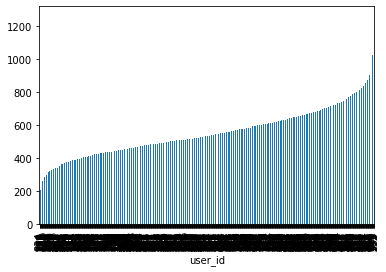

In [424]:
u_df[BDQTY].sort_values().plot(kind='bar')

In [434]:
# make tab for shop (item sold, average price, total sold)
s_df = pd.DataFrame()
s_df[SHOP] = total_df.groupby([SHOP])[[SHOP]].first().astype(int)
s_df[TPRICE] = total_df.groupby([SHOP])[[TPRICE]].sum().astype(float)
s_df[BQTY] = total_df.groupby([SHOP])[[QTY]].sum().astype(int)
s_df[BDQTY] = total_df.groupby([SHOP])[[ITEM]].count()
s_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, 0 to 59
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   shop_id          59 non-null     int64  
 1   total_price      59 non-null     float64
 2   item_count       59 non-null     int64  
 3   item_dist_count  59 non-null     int64  
dtypes: float64(1), int64(3)
memory usage: 2.4 KB


<AxesSubplot:xlabel='shop_id'>

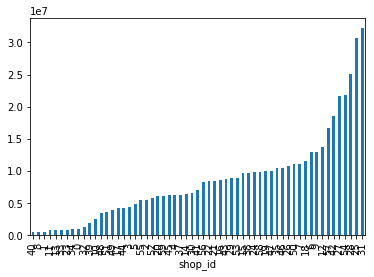

In [425]:
s_df[TPRICE].sort_values().plot(kind='bar')

<AxesSubplot:xlabel='shop_id'>

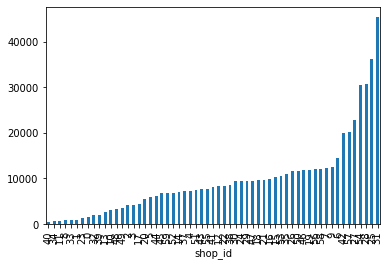

In [426]:
s_df[BQTY].sort_values().plot(kind='bar')

<AxesSubplot:xlabel='shop_id'>

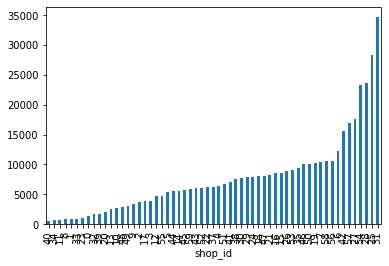

In [427]:
s_df[BDQTY].sort_values().plot(kind='bar')

In [472]:
# make time series to see spendings over time
d_df = pd.DataFrame(index=total_df[DATE].unique())
d_df[TPRICE] = total_df.groupby([DATE])[[TPRICE]].sum().astype(float)
d_df[BQTY] = total_df.groupby([DATE])[[QTY]].sum().astype(int)
d_df[BDQTY] = total_df.groupby([DATE])[[ITEM]].count()
d_df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 203 entries, 2013-01-01 to 2013-06-12
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   total_price      203 non-null    float64
 1   item_count       203 non-null    int64  
 2   item_dist_count  203 non-null    int64  
dtypes: float64(1), int64(2)
memory usage: 6.3 KB


<AxesSubplot:>

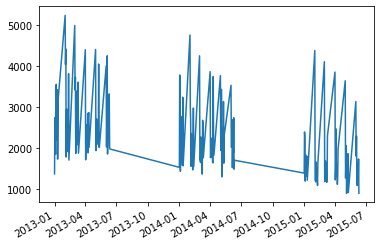

In [473]:
d_df[BDQTY].plot()


<AxesSubplot:>

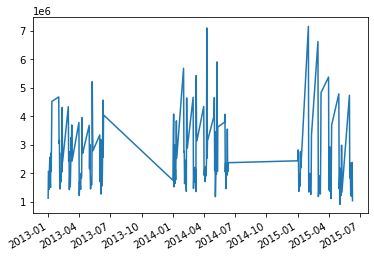

In [474]:
d_df[TPRICE].plot()

<AxesSubplot:>

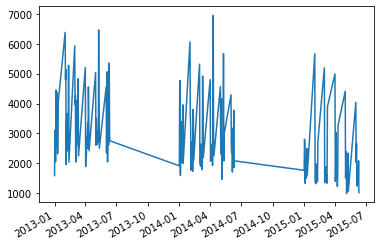

In [475]:
d_df[BQTY].plot()

## Spazio query marce

In [382]:
# 170 - triplette con basket id diversi
stored_basket_df.groupby(basket_dependent_attributes)[BASKET].nunique().sort_values()[-170:]

date        shop_id  user_id
2013-05-04  4        191        2
2014-02-05  6        308        2
2013-04-02  43       257        2
2014-01-10  58       441        2
2015-04-02  49       203        2
                               ..
2013-02-12  16       100        3
2013-06-05  49       203        3
2014-01-06  7        571        3
2014-02-09  53       580        4
2014-05-04  25       102        4
Name: basket_id, Length: 170, dtype: int64

In [383]:
# 3307 - ordini con una sola riga
stored_basket_df.groupby('basket_id').size().sort_values()[:3310]

basket_id
B869996     1
B5120383    1
B8617328    1
B8633312    1
B8617336    1
           ..
B8610368    1
B8612872    1
B8611812    2
B8614448    2
B8623836    2
Length: 3310, dtype: int64

## Spazio grafici

<AxesSubplot:>

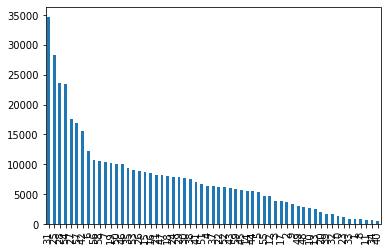

In [384]:
clean_basket_df['shop_id'].value_counts().plot(kind='bar')

<AxesSubplot:xlabel='item_price', ylabel='item_cnt_day'>

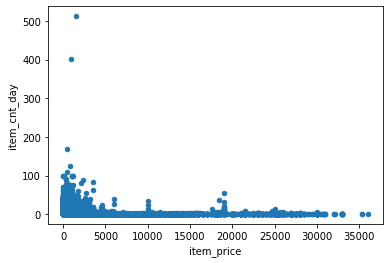

In [385]:
clean_basket_df.plot(x='item_price', y='item_cnt_day', kind='scatter')

## Spazio cazzeggio

In [387]:
df = pd.DataFrame([[4,9],[4,3],[4,9],[4,3],[4, np.nan],[3,1],[3,np.nan],[2,np.nan],[np.nan,2], [np.nan,3]], columns=['A', 'B'])

In [388]:
df

,A,B
0,4.0,9.0
1,4.0,3.0
2,4.0,9.0
3,4.0,3.0
4,4.0,NaN
5,3.0,1.0
6,3.0,NaN
7,2.0,NaN
8,NaN,2.0
9,NaN,3.0


In [389]:
df['B'] = df.groupby('A')['B'].apply(lambda x: x.fillna(x.mode().iloc[0]) if len(x.mode()) == 1 else x)

In [390]:
df

,A,B
0,4.0,9.0
1,4.0,3.0
2,4.0,9.0
3,4.0,3.0
4,4.0,NaN
5,3.0,1.0
6,3.0,1.0
7,2.0,NaN
8,NaN,NaN
9,NaN,NaN


In [391]:
df['B'] = df.groupby('A')['B'].apply(lambda x: x.replace(0 if len(x.mode()) > 1 else x))

In [392]:
# df.loc[df.groupby('A')['B'].agg(lambda x: len(x.mode())) > 1, 'B'] = 0


### TDL

basket id has trailing '.0'